In [1]:
import torch
import torch.nn as nn
import os
import argparse
import matplotlib.pyplot as plt
from core.model import build_model
from os.path import join as ospj
from dataset_prostate import *
from tqdm import tqdm
import torchvision
from collections import OrderedDict, defaultdict
import torchvision.utils as vutils

class CheckpointIO(object):
    def __init__(self, fname_template, data_parallel=False, **kwargs):
        os.makedirs(os.path.dirname(fname_template), exist_ok=True)
        self.fname_template = fname_template
        self.module_dict = kwargs
        self.data_parallel = data_parallel

    def register(self, **kwargs):
        self.module_dict.update(kwargs)

    def save(self, step):
        fname = self.fname_template.format(step)
        print('Saving checkpoint into %s...' % fname)
        outdict = {}
        for name, module in self.module_dict.items():
            if self.data_parallel:
                outdict[name] = module.module.state_dict()
            else:
                outdict[name] = module.state_dict()
        torch.save(outdict, fname)

    def load(self, step):
        fname = self.fname_template.format(step)
        assert os.path.exists(fname), fname + ' does not exist!'
        print('Loading checkpoint from %s...' % fname)
        if torch.cuda.is_available():
            module_dict = torch.load(fname)
        else:
            module_dict = torch.load(fname, map_location=torch.device('cpu'))
        
        for name, module in self.module_dict.items():
            model_wts = module.state_dict()
            
            if self.data_parallel:
                print('data_parallel')
                module.module.load_state_dict(model_wts)
            else:
                print('naah')
                module.load_state_dict(model_wts)
                
                
def load_checkpoint(ckptios,step):
    for ckptio in ckptios:
        ckptio.load(step)
        
@torch.no_grad()
def translate_and_reconstruct(nets, args, x_src, y_src, x_ref, y_ref):
    print(x_src.size())
    N, C, H, W = x_src.size()
    s_ref = nets.style_encoder(x_ref, y_ref)
    
    s_ref = s_ref.squeeze_(0)
    
    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
    x_fake = nets.generator(x_src, s_ref, masks=masks)
    s_src = nets.style_encoder(x_src, y_src)
    masks = nets.fan.get_heatmap(x_fake) if args.w_hpf > 0 else None
    
    s_src = s_src.squeeze_(0)
    
    x_rec = nets.generator(x_fake, s_src, masks=masks)
    x_concat = [x_src, x_ref, x_fake, x_rec]
    x_concat = torch.cat(x_concat, dim=0)
    del x_concat


@torch.no_grad()
def translate_using_latent(nets, args, x_src, x_ref, y_trg_list, z_trg_list, psi):
    N, C, H, W = x_src.size()
    latent_dim = z_trg_list[0].size(1)
    x_concat = [x_src]
    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

    for i, y_trg in enumerate(y_trg_list):
        z_many = torch.randn(10000, latent_dim).to(x_src.device)
        y_many = torch.LongTensor(10000).to(x_src.device).fill_(y_trg[0].item())
        s_many = nets.mapping_network(z_many, y_many)
        s_avg = torch.mean(s_many, dim=0, keepdim=True)
        s_avg = s_avg.repeat(N, 1)

        for z_trg in z_trg_list:
            s_trg = nets.mapping_network(z_trg, y_trg)
            s_trg = torch.lerp(s_avg, s_trg, psi)
            s_trg = s_trg.squeeze(1)
            x_fake = nets.generator(x_src, s_trg, masks=masks)
            x_concat += [x_fake]

    x_concat += [x_ref]
    x_concat = torch.cat(x_concat, dim=0)
    x_concat = denormalize(x_concat)
    
    return x_concat


@torch.no_grad()
def translate_using_reference(nets, args, x_src, x_ref, y_ref):
    N, C, H, W = x_src.size()
    wb = torch.ones(1, C, H, W).to(x_src.device)
    x_src_with_wb = torch.cat([wb, x_src], dim=0)

    masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
    s_ref = nets.style_encoder(x_ref, y_ref)
    
    s_ref = s_ref.squeeze_(0)
    
    s_ref_list = s_ref.unsqueeze(1).repeat(1, N, 1)
    x_concat = [x_src_with_wb]
    
#     print("s_ref",s_ref.shape)
#     print("s_ref_list",s_ref_list.shape)
    
    for i, s_ref in enumerate(s_ref_list):
        
#         s_ref = s_ref.squeeze_(0)
        
        x_fake = nets.generator(x_src, s_ref, masks=masks)
        x_fake_with_ref = torch.cat([x_ref[i:i+1], x_fake], dim=0)
        x_concat += [x_fake_with_ref]

    x_concat = torch.cat(x_concat, dim=0)
    x_concat = denormalize(x_concat)
    
    return x_concat
    
@torch.no_grad()
def debug_image(nets, args, inputs, step):
    x_src, y_src = inputs.x_src, inputs.y_src
    x_ref, y_ref = inputs.x_ref, inputs.y_ref
    
#     print("before padding",x_src.shape)
    
    x_src = F.pad(input=x_src, pad=(8, 8, 8, 8), mode='constant', value=0)
    x_ref = F.pad(input=x_ref, pad=(8, 8, 8, 8), mode='constant', value=0)

    # tensor shape from 3D ----> 4D

    x_src = x_src.unsqueeze_(1).float()
    x_ref = x_ref.unsqueeze_(1).float()

    device = inputs.x_src.device
    N = inputs.x_src.size(0)

    # translate and reconstruct (reference-guided)

    # latent-guided image synthesis
    y_trg_list = [torch.tensor(y).repeat(N).to(device)
                  for y in range(min(args.num_domains, 5))]
    z_trg_list = torch.randn(args.num_outs_per_domain, 1, args.latent_dim).repeat(1, N, 1).to(device)
    for psi in [0.5, 0.7, 1.0]:
        filename = ospj(args.sample_dir, '%06d_latent_psi_%.1f.jpg' % (step, psi))
        translate_using_latent(nets, args, x_src, y_trg_list, z_trg_list, psi, filename)

    # reference-guided image synthesis
    filename = ospj(args.sample_dir, '%06d_reference.jpg' % (step))
    translate_using_reference(nets, args, x_src, x_ref, y_ref, filename)
    
def denormalize(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

def save_image(x, ncol, filename):
    x = denormalize(x)
    vutils.save_image(x.cpu(), filename, nrow=ncol, padding=0)


In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--img_size', type=int, default=256,
                    help='Image resolution')
parser.add_argument('--num_domains', type=int, default=3,
                    help='Number of domains')
parser.add_argument('--latent_dim', type=int, default=16,
                    help='Latent vector dimension')
parser.add_argument('--hidden_dim', type=int, default=512,
                    help='Hidden dimension of mapping network')
parser.add_argument('--style_dim', type=int, default=64,
                    help='Style code dimension')

# weight for objective functions
parser.add_argument('--lambda_reg', type=float, default=1,
                    help='Weight for R1 regularization')
parser.add_argument('--lambda_cyc', type=float, default=1,
                    help='Weight for cyclic consistency loss')
parser.add_argument('--lambda_sty', type=float, default=1,
                    help='Weight for style reconstruction loss')
parser.add_argument('--lambda_ds', type=float, default=1,
                    help='Weight for diversity sensitive loss')
parser.add_argument('--ds_iter', type=int, default=100000,
                    help='Number of iterations to optimize diversity sensitive loss')
parser.add_argument('--w_hpf', type=float, default=1,
                    help='weight for high-pass filtering')

# training arguments
parser.add_argument('--randcrop_prob', type=float, default=0.5,
                    help='Probabilty of using random-resized cropping')
parser.add_argument('--total_iters', type=int, default=120000,
                    help='Number of total iterations')
parser.add_argument('--resume_iter', type=int, default=0,
                    help='Iterations to resume training/testing')
parser.add_argument('--batch_size', type=int, default=1, 
                    help='Batch size for training') #8
parser.add_argument('--val_batch_size', type=int, default=1,
                    help='Batch size for validation') #32
parser.add_argument('--lr', type=float, default=1e-4,
                    help='Learning rate for D, E and G')
parser.add_argument('--f_lr', type=float, default=1e-6,
                    help='Learning rate for F')
parser.add_argument('--beta1', type=float, default=0.0,
                    help='Decay rate for 1st moment of Adam')
parser.add_argument('--beta2', type=float, default=0.99,
                    help='Decay rate for 2nd moment of Adam')
parser.add_argument('--weight_decay', type=float, default=1e-4,
                    help='Weight decay for optimizer')
parser.add_argument('--num_outs_per_domain', type=int, default=1,
                    help='Number of generated images per domain during sampling')
# misc
#     parser.add_argument('--mode', type=str, required=True,
#                         choices=['train', 'sample', 'eval', 'align'],

#                         help='This argument is used in solver')
parser.add_argument('--mode',type=str, default = 'train')
parser.add_argument('--num_workers', type=int, default=4,
                    help='Number of workers used in DataLoader')
parser.add_argument('--seed', type=int, default=777,
                    help='Seed for random number generator')

# directory for training
parser.add_argument('--train_path',type=str,default='/media/Data16T/MRI/datasets/ProstateX_dce_h5')
parser.add_argument('--validation_path',type=str,default='/media/Data16T/MRI/datasets/ProstateX_dce_h5')
# parser.add_argument('--acceleration_factor',type=str,default=['4x'])
parser.add_argument('--dataset_type_1',type=str,default=['DCE_01','DCE_02','DCE_03'])
parser.add_argument('--dataset_type_2',type=str,default=['DCE_01','DCE_02','DCE_03'])
# parser.add_argument('--mask_type',type=str,default=['cartesian'])


parser.add_argument('--sample_dir', type=str, default='exp_Dce1Dce2-Dce2Dce3_reference/sample_dir',
                    help='Directory for saving generated images')
parser.add_argument('--checkpoint_dir', type=str, default='exp_Dce1Dce2-Dce2Dce3_reference/checkpoint_dir',
                    help='Directory for saving network checkpoints')

# directory for calculating metrics
parser.add_argument('--eval_dir', type=str, default='exp_Dce1Dce2-Dce2Dce3_reference/eval_dir',
                    help='Directory for saving metrics, i.e., FID and LPIPS')

# directory for testing
parser.add_argument('--result_dir', type=str, default='exp_Dce1Dce2-Dce2Dce3_reference/result_dir',
                    help='Directory for saving generated images and videos')
#     parser.add_argument('--src_dir', type=str, default='assets/representative/celeba_hq/src',
#                         help='Directory containing input source images')
#     parser.add_argument('--ref_dir', type=str, default='assets/representative/celeba_hq/ref',
#                         help='Directory containing input reference images')
parser.add_argument('--inp_dir', type=str, default='exp_Dce1Dce2-Dce2Dce3_reference/input_dir',
                    help='input directory when aligning faces')
parser.add_argument('--out_dir', type=str, default='exp_Dce1Dce2-Dce2Dce3_reference/output_dir',
                    help='output directory when aligning faces')

parser.add_argument('--device', type=str, default='cuda:0',
                    help='Which device to train on. Set to "cuda" to use the GPU')

# face alignment
parser.add_argument('--wing_path', type=str, default=None)
parser.add_argument('--lm_path', type=str, default=None)

# step size
parser.add_argument('--print_every', type=int, default=100)
parser.add_argument('--sample_every', type=int, default=2500)#2500
parser.add_argument('--save_every', type=int, default=5000) 
#     parser.add_argument('--save_every', type=int, default=500) 
parser.add_argument('--eval_every', type=int, default=5000)#10000
#     parser.add_argument('--eval_every', type=int, default=500)

args = parser.parse_args("")
# acc_factors = args.acceleration_factor#.split(',')
# mask_types = args.mask_type#.split(',')
dataset_type_1 = args.dataset_type_1#.split(',')  
torch.manual_seed(args.seed)

In [3]:
nets, nets_ema = build_model(args)
# ckptios = [CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets_ema.pt'), data_parallel=False, **nets_ema)]
# load_checkpoint(ckptios,args.resume_iter)
del nets
m = torch.load('/media/Data16T/gayathri/stargan-v2-prostate-working-2/exp_Dce1Dce2-Dce2Dce3_reference/checkpoint_dir/110000_nets_ema.pt')
nets_ema['mapping_network'].load_state_dict(m['mapping_network'])
nets_ema['generator'].load_state_dict(m['generator'])
nets_ema['style_encoder'].load_state_dict(m['style_encoder'])
nets_ema['fan'].load_state_dict(m['fan'])
loader = torch.utils.data.DataLoader(SliceDataProstate(args.validation_path,mode='test'),batch_size=args.batch_size,shuffle=False)
fetcher = InputFetcher_v2(loader, args.latent_dim, 'val')

i = 0

In [4]:
print(nets_ema.keys())

dict_keys(['generator', 'mapping_network', 'style_encoder', 'fan'])


In [5]:
device = 'cuda:0'
[nets_ema[key].to(device) for key in nets_ema.keys()]
nets = nets_ema
del nets_ema
# nets.generator = nets.generator.module.cpu()
# nets.mapping_network = nets.mapping_network.module.cpu()
# nets.style_encoder = nets.style_encoder.module.cpu()
# nets.fan = nets.fan.module.cpu()

In [6]:
def def_value():
    return []

loader = torch.utils.data.DataLoader(SliceDataProstate(args.validation_path,mode='test'),batch_size=1,shuffle=False)
mode = 'reference'
task_preds = defaultdict(def_value)
loop = tqdm(loader)

with torch.no_grad():
    for i, (x_src, y_src, x_trg, y_trg, src_domain, trg_domain) in enumerate(loop):

        x_src, y_src, x_trg, y_trg = x_src.to(device), y_src.to(device), x_trg.to(device), y_trg.to(device)
        x_src = F.pad(input=x_src, pad=(8, 8, 8, 8), mode='replicate')
        x_src = x_src.unsqueeze_(1).float()
        x_trg = F.pad(input=x_trg, pad=(8, 8, 8, 8), mode='replicate')
        x_trg = x_trg.unsqueeze_(1).float()
        masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None
        N = x_src.size(0)
        task = '%s2%s' % (src_domain[0], trg_domain[0])
        group_of_images = []

        if mode == 'latent':
            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
        else:
    #         x_trg = F.pad(input=x_trg, pad=(8, 8, 8, 8), mode='replicate')
    #         x_trg = x_trg.unsqueeze_(1).float()

            if x_trg.size(0) > N:
                x_trg = x_trg[:N]
            s_trg = nets.style_encoder(x_trg, y_trg)

    #         print(f'eval, x_src: {x_src.shape}, s_trg: {s_trg.shape}, masks: {masks[0].shape, masks[1].shape}')
    #         s_trg = s_trg.squeeze(1)
        x_fake = nets.generator(x_src, s_trg, masks=masks)
    #     print(f'x_src: {x_src.shape}, x_fake: {x_fake.shape}, x_trg: {x_trg.shape}')
        x_all = torch.cat((x_src,x_fake,x_trg),dim=1)
        task_preds[task].append(x_all.cpu().detach().numpy())
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3312/3312 [01:06<00:00, 50.00it/s]


In [7]:
nets.keys()

dict_keys(['generator', 'mapping_network', 'style_encoder', 'fan'])

In [8]:
next(nets.fan.parameters()).is_cuda

True

In [9]:
task_preds.keys()

dict_keys(['DCE_012DCE_02', 'DCE_012DCE_03', 'DCE_022DCE_03'])

In [10]:
task_preds['DCE_022DCE_03'][0].shape

(1, 3, 256, 256)

In [16]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
from statistics import mean, stdev

for task in task_preds.keys():
    y = task_preds[task]
    psnr = []
    ssim = []
    for x in y:
        fake = x[0,1,:,:]
        gt = x[0,2,:,:]
        psnr.append(peak_signal_noise_ratio(fake, gt, data_range=gt.max()))
        ssim.append(structural_similarity(fake, gt, data_range=gt.max()))
        
    print('Task: ',task)
    print(f'PSNR: {mean(psnr)} +/- {2*stdev(psnr)}, SSIM: {mean(ssim)} +/- {2*stdev(ssim)}')

Task:  DCE_012DCE_02
PSNR: 19.728375767073263 +/- 3.547117015892083, SSIM: 0.608618529519548 +/- 0.13102182604582804
Task:  DCE_012DCE_03
PSNR: 16.61754148576603 +/- 4.025815519882937, SSIM: 0.5323408084143857 +/- 0.13582792865054027
Task:  DCE_022DCE_03
PSNR: 19.550508072739717 +/- 4.818123996365905, SSIM: 0.674860982218346 +/- 0.12526612489552988


# DCE_012DCE_02

0   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


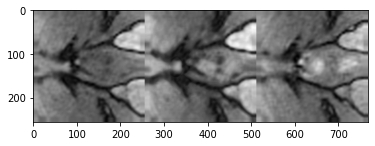

1   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


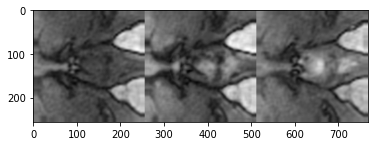

2   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


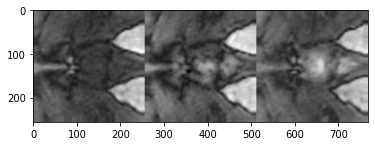

3   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


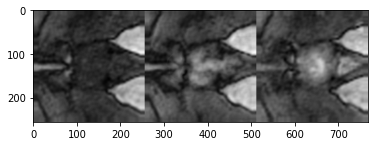

4   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


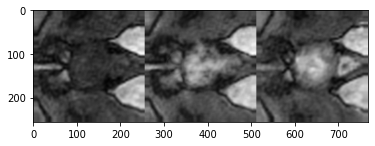

5   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


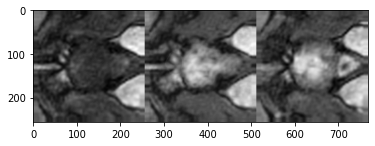

6   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


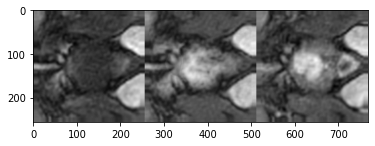

7   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


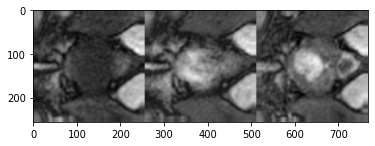

8   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


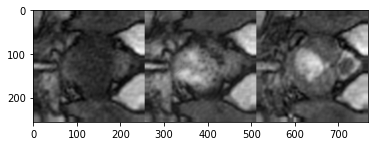

9   Source:DCE_1,  Fake:DCE_2,   GT:DCE_2


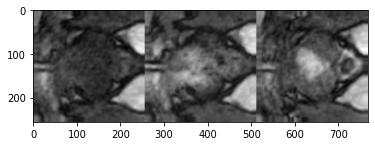

In [11]:
y = task_preds['DCE_012DCE_02']
for i in range(10):
    print(i,"  Source:DCE_1,  Fake:DCE_2,   GT:DCE_2")
    x = y[i]
    src = x[0,0,:,:]
    fake = x[0,1,:,:]
    gt = x[0,2,:,:]
    img = np.concatenate([src,fake,gt],axis=1)
    plt.imshow(img,cmap='gray')
    plt.show()

# DCE_012DCE_03

0   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


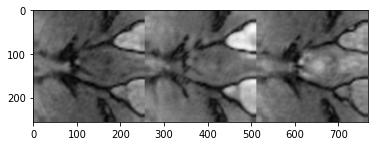

1   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


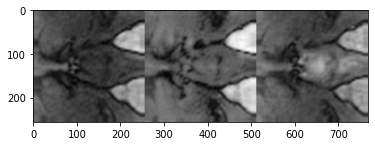

2   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


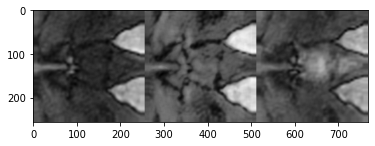

3   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


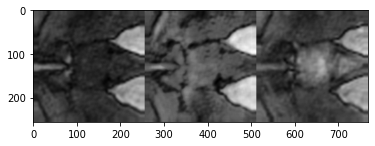

4   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


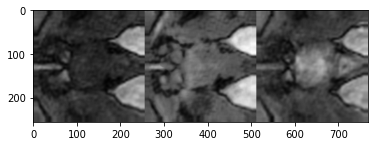

5   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


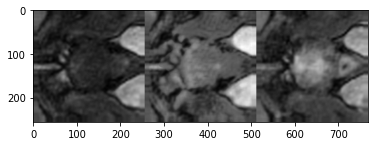

6   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


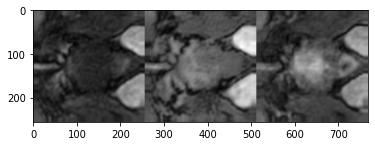

7   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


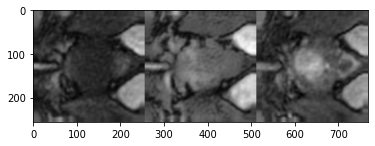

8   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


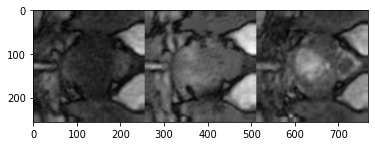

9   Source:DCE_1,  Fake:DCE_3,   GT:DCE_3


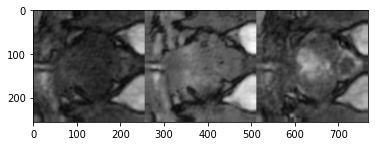

In [14]:
y = task_preds['DCE_012DCE_03']
for j in range(10):
    print(j,"  Source:DCE_1,  Fake:DCE_3,   GT:DCE_3")
    x = y[j]
    src = x[0,0,:,:]
    fake = x[0,1,:,:]
    gt = x[0,2,:,:]
    img = np.concatenate([src,fake,gt],axis=1)
    plt.imshow(img,cmap='gray')
    plt.show()

# DCE_022DCE_03

0   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


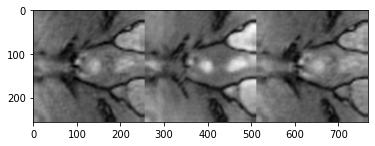

1   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


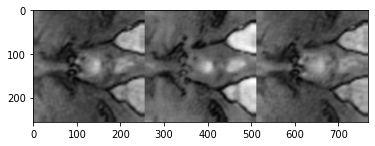

2   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


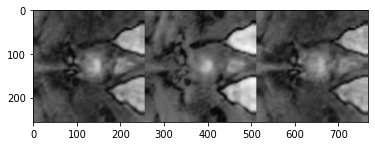

3   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


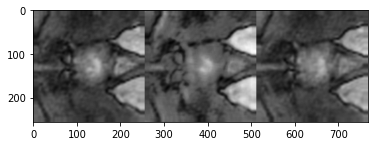

4   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


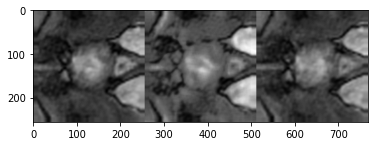

5   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


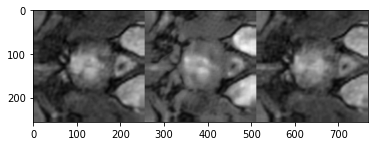

6   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


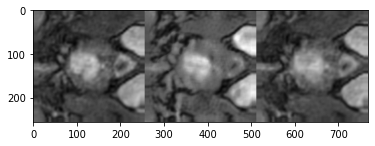

7   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


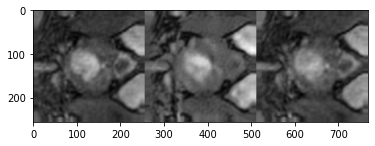

8   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


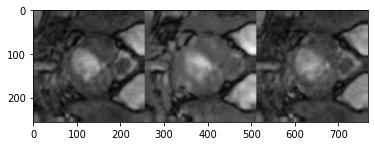

9   Source:DCE_2,  Fake:DCE_3,   GT:DCE_3


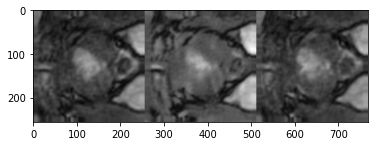

In [13]:
y = task_preds['DCE_022DCE_03']
for k in range(10):
    print(k,"  Source:DCE_2,  Fake:DCE_3,   GT:DCE_3")
    x = y[k]
    src = x[0,0,:,:]
    fake = x[0,1,:,:]
    gt = x[0,2,:,:]
    img = np.concatenate([src,fake,gt],axis=1)
    plt.imshow(img,cmap='gray')
    plt.show()

In [15]:
!nvidia-smi

Thu Jul 27 15:05:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0 Off |                  N/A |
|  0%   44C    P8    32W / 350W |   9962MiB / 24259MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------